In [1]:
from tkinter import W
from trace import Trace
import pandas as pd
import numpy as np
import nltk
import pickle
import csv
import matplotlib.pyplot as plt
#nltk.download()

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix, recall_score

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\larao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\larao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\larao\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\larao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\larao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pickle
hate_data, hate_labels = [], [] 
with open("dataset/hate_dataset", "rb") as fp:     
    hate_data= pickle.load(fp)
with open("dataset/hate_labels", "rb") as fp:     
    hate_labels= pickle.load(fp)

#print(hate_data)


In [4]:
hate_data = pd.DataFrame(hate_data)

hate_data[0].dropna(inplace=True)
hate_data[0] = [entry.lower() for entry in hate_data[0]] # all lowercase
hate_data[0]= [word_tokenize(entry) for entry in hate_data[0]] # tokenization
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ #seperate adjectives
tag_map['V'] = wn.VERB #seperate verbs
tag_map['R'] = wn.ADV #seperate adverbs

In [5]:
for index,entry in enumerate(hate_data[0]):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    hate_data.loc[index,'text_final'] = str(Final_words)
    
print("Finished preprocessing")
    

Finished preprocessing


In [6]:
hate_labels = pd.DataFrame(hate_labels)

In [7]:
Train_X, Data_X, Train_Y, Data_Y = model_selection.train_test_split(hate_data['text_final'],hate_labels[0],test_size=0.3)
Test_X, Val_X, Test_Y, Val_Y = model_selection.train_test_split(Data_X,Data_Y,test_size=1/3)
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Val_Y = Encoder.fit_transform(Val_Y)
Test_Y = Encoder.fit_transform(Test_Y)
print(Train_X.shape)
print(Val_Y.shape)
print(Test_Y.shape)

(18770,)
(2682,)
(5363,)


In [8]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(hate_data['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Val_X_Tfidf = Tfidf_vect.transform(Val_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
print(Train_X_Tfidf.shape)

(18770, 5000)


In [9]:
def conf_matrix_table(cf_matrix):
    group_names = ['TN','FP','FN','TP']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, cf_matrix.flatten(), group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.show()

Naive Bayes Accuracy Score ->  80.98434004474274  alpha =  0.001
Naive Bayes Accuracy Score ->  81.3944817300522  alpha =  0.01
Naive Bayes Accuracy Score ->  81.73005219985086  alpha =  0.1
Naive Bayes Accuracy Score ->  81.20805369127517  alpha =  1
Naive Bayes Accuracy Score ->  67.37509321401939  alpha =  10


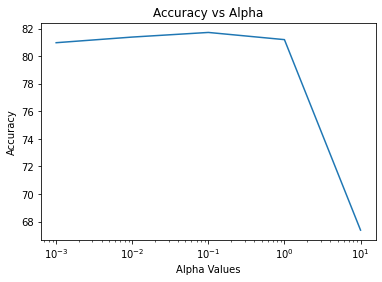

Optimum alpha = 0.1  with accuracy score ->  81.73005219985086
Naive Bayes Accuracy Score ->  81.98769345515569
Precision ->  0.8067184758084733
Recall ->  0.9428655142103721
F1 Score ->  0.8694947311537423


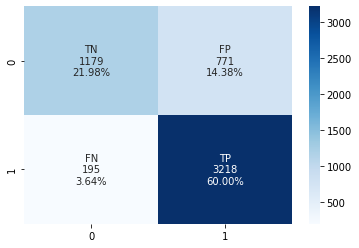

True Positive 3218
True Negative 1179
False Positive 771
False Negative 195
NPV ->  0.8580786026200873
FPR ->  0.3953846153846154
FDR ->  0.1932815241915267


In [10]:
# fit the training dataset on the NB classifier
alphas = [0.001, 0.01, 0.1, 1, 10]
accuracy_scores = []
for a in alphas:
    Naive = naive_bayes.MultinomialNB(alpha=a)
    Naive.fit(Train_X_Tfidf,Train_Y)
    predictions_NB = Naive.predict(Val_X_Tfidf)
    acc = accuracy_score(predictions_NB, Val_Y)*100
    accuracy_scores.append(acc)
    print("Naive Bayes Accuracy Score -> ", acc, " alpha = ", a)

#plot accuricies vs alphas
plt.semilogx(alphas, accuracy_scores)
plt.title("Accuracy vs Alpha")
plt.xlabel("Alpha Values")
plt.ylabel("Accuracy")
plt.show()

#optimum parameter
opt_i = np.argmax(accuracy_scores)
print("Optimum alpha =", alphas[opt_i], " with accuracy score -> ", accuracy_scores[opt_i])

#Test the model on test set with the optimum alpha
Naive = naive_bayes.MultinomialNB(alpha=alphas[opt_i])
Naive.fit(Train_X_Tfidf,Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)
acc = accuracy_score(predictions_NB, Test_Y)*100

print("Naive Bayes Accuracy Score -> ", acc)
print("Precision -> ", precision_score(Test_Y, predictions_NB, average="binary"))
print("Recall -> ", recall_score(Test_Y, predictions_NB, average="binary"))
print("F1 Score -> ", f1_score(Test_Y, predictions_NB, average="binary"))
cm = confusion_matrix(Test_Y, predictions_NB, labels=[0, 1])
conf_matrix_table(cm)
tn, fp, fn, tp = confusion_matrix(list(Test_Y), list(predictions_NB), labels=[0, 1]).ravel()
print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

npv = tn / (tn+fn)
print("NPV -> ", npv)
fpr = fp / (fp+tn)
print("FPR -> ", fpr)
fdr = fp / (tp+fp)
print("FDR -> ", fdr)

In [11]:
#SVM
#print(Train_Y.shape)
# gamma = 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1
# c = 10**-3, 10**-2, 10**-1, 10**0, 10**1
SVM = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma=2**1)
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
print("Precision -> ", precision_score(Test_Y, predictions_SVM, average="binary"))
print("Recall -> ", recall_score(Test_Y, predictions_SVM, average="binary"))
print("F1 Score -> ", f1_score(Test_Y, predictions_SVM, average="binary"))
cm = confusion_matrix(Test_Y, predictions_SVM, labels=[0, 1])
print("Confusion Matrix -> ", cm)

tn, fp, fn, tp = confusion_matrix(list(Test_Y), list(predictions_SVM), labels=[0, 1]).ravel()
print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

npv = tn / (tn+fn)
print("NPV -> ", npv)
fpr = fp / (fp+tn)
print("FPR -> ", fpr)
fdr = fp / (tp+fp)
print("FDR -> ", fdr)

# filename = 'finalized_model.sav'
# pickle.dump(predictions_SVM, open(filename, 'wb'))

SVM Accuracy Score ->  90.84467648704083
Precision ->  0.9361194029850747
Recall ->  0.9188397304424261
F1 Score ->  0.9273990832470798
Confusion Matrix ->  [[1736  214]
 [ 277 3136]]
True Positive 3136
True Negative 1736
False Positive 214
False Negative 277
NPV ->  0.862394436164928
FPR ->  0.10974358974358975
FDR ->  0.06388059701492538


In [12]:
sentence = "trans women are real women" #input("Please enter a sentence:")
hate_data2 = []
hate_data2.append(sentence)

hate_data2 = pd.DataFrame(hate_data2)

hate_data2[0].dropna(inplace=True)
hate_data2[0] = [entry.lower() for entry in hate_data2[0]] # all lowercase
hate_data2[0]= [word_tokenize(entry) for entry in hate_data2[0]] # tokenization
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ #seperate adjectives
tag_map['V'] = wn.VERB #seperate verbs
tag_map['R'] = wn.ADV #seperate adverbs

for index,entry in enumerate(hate_data2[0]):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    hate_data2.loc[index,'text_final'] = str(Final_words)
    
print("Finished preprocessing")

print(hate_data2)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(hate_data['text_final'])
Test_X_Tfidf = Tfidf_vect.transform(hate_data2['text_final'])
print(Test_X_Tfidf.shape)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print(predictions_SVM)

Finished preprocessing
                                  0                           text_final
0  [trans, women, are, real, women]  ['trans', 'woman', 'real', 'woman']
(1, 5000)
[1]


In [13]:
#RFC
#RFC 
length = Train_X_Tfidf.shape[0]
RFC_Val_Results = []
epoch = 0
#Loop through possible hyperparameters
for i in range(100,301,100):
    for j in range(2,303,10):
        if j != 2:
            j -=2
        epoch += 1
        print(epoch)
        RFC = rfc(n_estimators = i,min_samples_split = j)
        RFC.fit(Train_X_Tfidf,Train_Y)
        predictions_RFC = RFC.predict(Val_X_Tfidf)
        RFC_ACC = accuracy_score(predictions_RFC, Val_Y)*100
        RFC_PRE = precision_score(predictions_RFC, Val_Y)*100
        RFC_REC = recall_score(predictions_RFC, Val_Y)*100
        RFC_F1 = f1_score(predictions_RFC, Val_Y)*100
        RFC_Val_Results.append(([RFC],RFC_ACC,RFC_PRE,RFC_REC,RFC_F1))




# print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
# print("Precision -> ", precision_score(Test_Y, predictions_SVM, average="binary"))
# print("Recall -> ", recall_score(Test_Y, predictions_SVM, average="binary"))
# print("F1 Score -> ", f1_score(Test_Y, predictions_SVM, average="binary"))
# cm = confusion_matrix(Test_Y, predictions_SVM, labels=[0, 1])
# print("Confusion Matrix -> ", cm)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93


In [17]:
#Dominated models are removed
# RFC_MAT = np.array(RFC_Results,dtype=object)
# a = False
# b = 0
# while a:
#     a = True
#     for k in RFC_Results:
#         for l in RFC_results:
#             if (k[1:5] < l[1:5]) == [True,True,True,True]:
#                 a = False
#                 RFC_Results.pop(RFC_Results.index(k))
#                 b += 1
# print(b)

# RFC_Val_Results = RFC_Results

# RFC_Val_MAT = np.array(RFC_Val_Results,dtype=object)

# idx = np.argpartition(RFC_Val_MAT[:,1], -5)[-5:]

# print(RFC_Val_MAT[idx])

In [16]:
# RFC_Test_Results[:,1]

In [15]:
# #RFC Testing
# RFC_Test_Results = []
# for i in idx:
#     i = int(i)
#     RFC = RFC_Val_MAT[i][0][0]
#     predictions_RFC = RFC.predict(Test_X_Tfidf)
#     RFC_ACC = accuracy_score(predictions_RFC, Test_Y)*100
#     RFC_PRE = precision_score(predictions_RFC, Test_Y)*100
#     RFC_REC = recall_score(predictions_RFC, Test_Y)*100
#     RFC_F1 = f1_score(predictions_RFC, Test_Y)*100
#     RFC_Test_Results.append((predictions_RFC,RFC_ACC,RFC_PRE,RFC_REC,RFC_F1))
#     print("\nFor model:"+ str(i))
#     print("SVM Accuracy Score -> ",RFC_ACC)
#     print("Precision -> ",RFC_PRE)
#     print("Recall -> ",RFC_REC)
#     print("F1 Score -> ",RFC_F1)
#     cm = confusion_matrix(Test_Y, predictions_RFC, labels=[0, 1])
#     print("Confusion Matrix -> ", cm)

# RFC_Test_Mat = np.array(RFC_Test_Results,dtype=object)

# x = [1,2,3,4,5]
# plt.figure()
# plt.title("RFC Accuracy")
# plt.plot(x,RFC_Val_MAT[idx,1],"b",label='RFC Validation')
# plt.plot(x,RFC_Test_Mat[:,1],"r",label='RFC Test')

# plt.figure()
# plt.title("RFC Accuracy")
# plt.plot(x,RFC_Val_MAT[idx,2],"b",label='RFC Validation')
# plt.plot(x,RFC_Test_Mat[:,2],"r",label='RFC Test')

# plt.figure()
# plt.title("RFC Recall")
# plt.plot(x,RFC_Val_MAT[idx,3],"b",label='RFC Validation')
# plt.plot(x,RFC_Test_Mat[:,3],"r",label='RFC Test')

# plt.figure()
# plt.title("RFC F1")
# plt.plot(x,RFC_Val_MAT[idx,4],"b",label='RFC Validation')
# plt.plot(x,RFC_Test_Mat[:,4],"r",label='RFC Test')
